In [1]:
import os
os.chdir('/pc_win_loss')

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import lightgbm as lgb

from functions.visualizer import *
from src.config import *

## データ取り込み

In [3]:
df = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')
df.head()

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0


## ベースモデル構築

In [4]:
# 20%の被験者を選ぶ
df_train, df_val = train_test_split(df, test_size=0.2)

print(len(df_train))
print(len(df_val))

6400
1600


### LightGBM実装

In [5]:
feature_cols = list(df.iloc[:, :-1].columns)

train_x = df_train.iloc[:, :-1]
train_y = df_train[COL_BLUEWINS]

val_x = df_val.iloc[:, :-1]
val_y = df_val[COL_BLUEWINS]

In [6]:
model = lgb.LGBMClassifier()
model.fit(train_x, train_y)

LGBMClassifier()

In [7]:
# 検証データを用いて予測
pred_y = model.predict(val_x)

accuracy = accuracy_score(pred_y, val_y)
print(f"accuracy score: {accuracy:0.4f}")

accuracy score: 0.7906


ベースモデルの精度は8割弱

<AxesSubplot:>

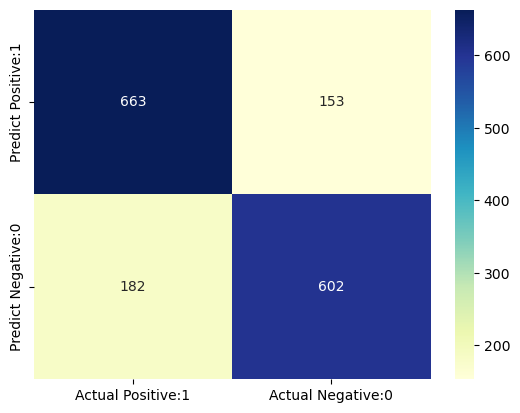

In [8]:
cm = confusion_matrix(val_y, pred_y)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### 変数重要度の確認

In [9]:
df_importance = pd.DataFrame(model.feature_importances_, index=feature_cols, columns=['importance'])
df_importance['importance'] = df_importance['importance'] / sum(df_importance['importance'])
display(df_importance)

,importance
gameId,0.294667
blueFirstBlood,0.028333
blueKills,0.123333
blueDeaths,0.115000
blueAssists,0.113667
blueEliteMonsters,0.046000
blueDragons,0.024000
blueTotalGold,0.158333
blueTotalExperience,0.096667


In [10]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot.index                         # 特徴量のカラム名を取得
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル

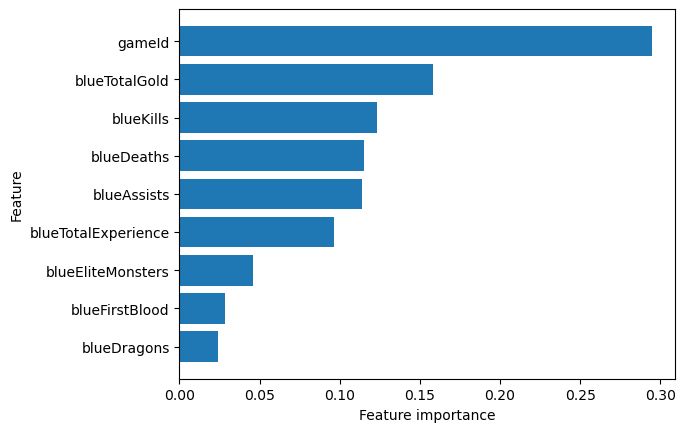

In [11]:
plot_feature_importance(df_importance)